In [2]:
%load_ext autoreload
%autoreload 2

import os
from os.path import join
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import h5py
import MAS_library as MASL
import Pk_library as PKL
mpl.style.use('style.mcstyle')


In [3]:
sdir = '/home/mattho/git/ltu-cmass/data/testlc/borgpm/L3000-N384/100'
os.listdir(sdir)

['rho_transfer.npy', 'config.yaml', 'snapshots.h5', 'halos.h5', 'hod', 'obs']

In [19]:
with h5py.File(join(sdir, 'snapshots.h5'), 'r') as f:
    keys = list(f.keys())
print(keys)
rhos = []
with h5py.File(join(sdir, 'snapshots.h5'), 'r') as f:
    # asave = f.attrs['asave']
    for key in keys:
        rho = np.array(f[key]['rho'])
        rhos.append(rho)
rhos = np.stack(rhos, axis=0)

['0.601000', '0.626000', '0.651000', '0.676000', '0.702000']


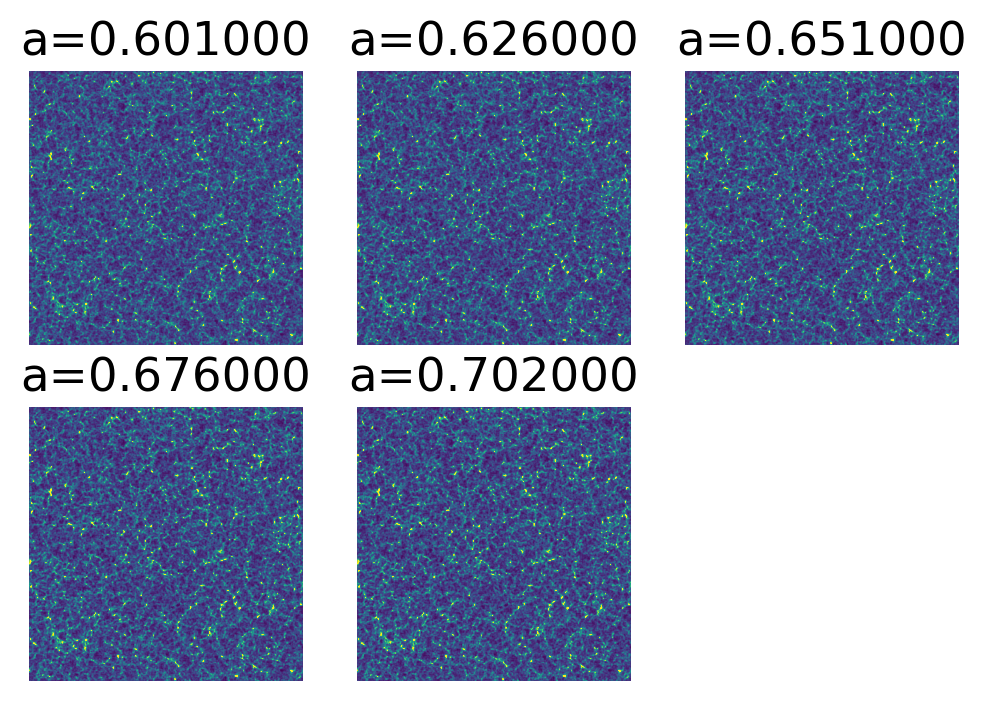

In [20]:
f, axs = plt.subplots(2, (len(keys)+1)//2, figsize=(6,4))
axs = axs.flatten()

for i in range(len(keys)):
    ax = axs[i]
    rho = rhos[i]
    ax.imshow(rho[50], vmin=-1, vmax=3)
    ax.set_title(f'a={keys[i]}')
for ax in axs:
    ax.axis('off')

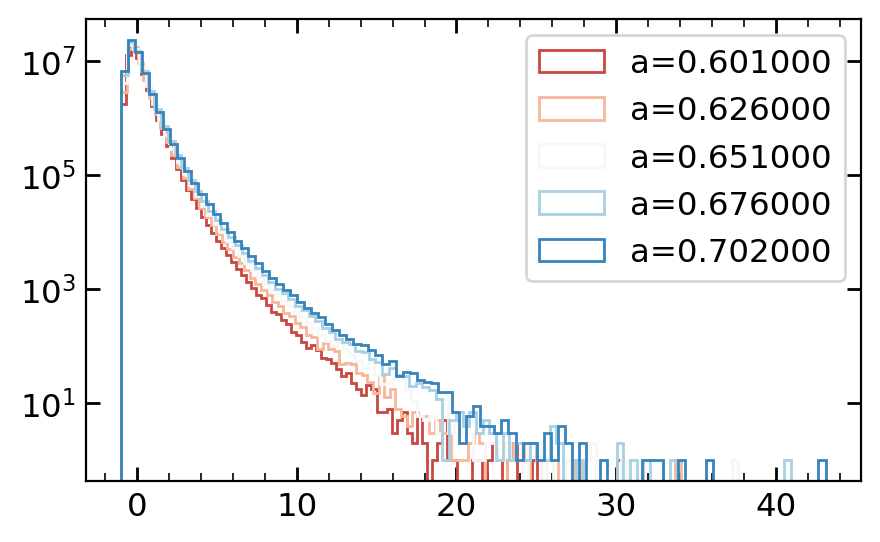

In [21]:
f, ax = plt.subplots(1, 1, figsize=(5,3))
ax.semilogy()
cmap = sns.color_palette('RdBu', n_colors=len(keys))
for i, key in enumerate(keys):
    rho = rhos[i]
    ax.hist(rho.flatten(), bins=100, histtype='step', label=f'a={key}', color=cmap[i])
ax.legend()

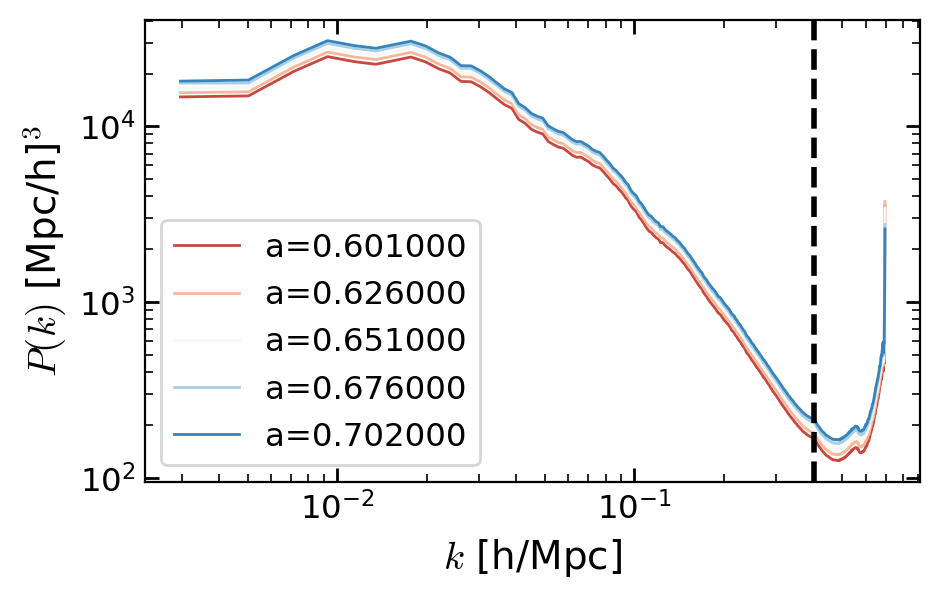

In [23]:
f, ax = plt.subplots(1, 1, figsize=(5,3))
ax.loglog()
cmap = sns.color_palette('RdBu', n_colors=len(keys))
for i, key in enumerate(keys):
    rho = rhos[i]
    Pk = PKL.Pk(rho, BoxSize=3000, axis=0, MAS='CIC', verbose=False)
    ax.plot(Pk.k3D, Pk.Pk[:,0], label=f'a={key}', color=cmap[i], lw=1)
ax.legend()
ax.set(xlabel=r'$k$ [h/Mpc]', ylabel=r'$P(k)$ [Mpc/h]$^3$')

nyq = np.pi*384/3000
ax.axvline(nyq, color='k', ls='--');


In [24]:
i = 1
with h5py.File(join(sdir, 'halos.h5'), 'r') as f:
    keys = list(f.keys())
    key = keys[i]
    hpos = np.array(f[key]['pos'])
    hvel = np.array(f[key]['vel'])
    hmass = np.array(f[key]['mass'])

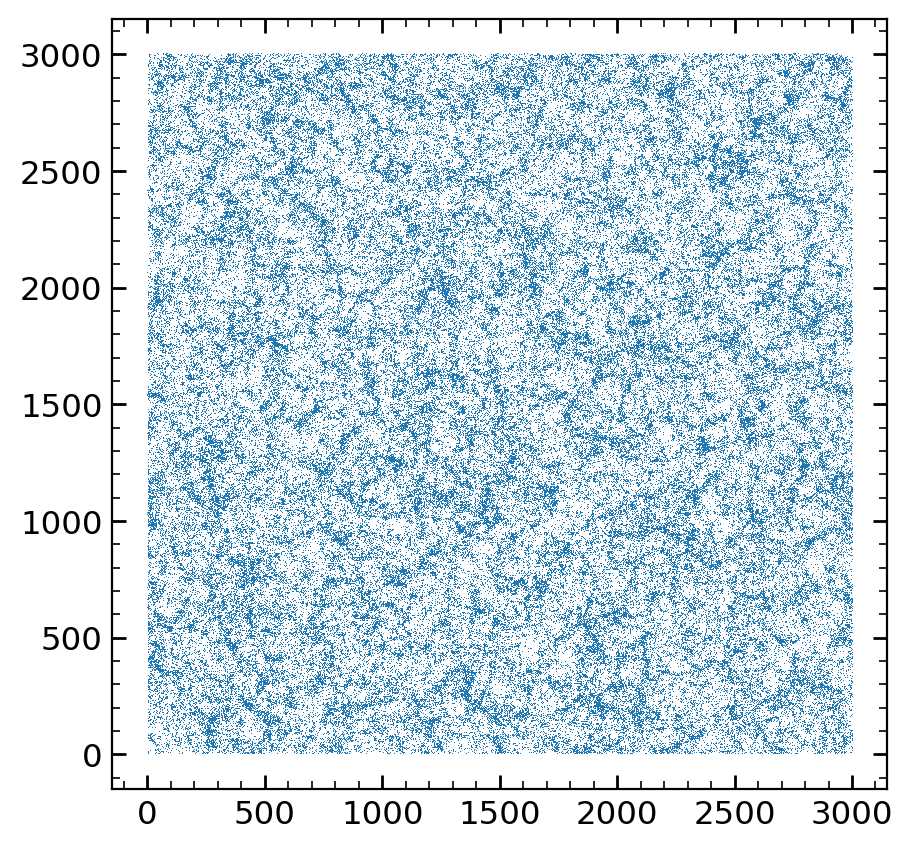

In [25]:
def mask_halos(hpos, i, di, axis=0):
    mask = (hpos[:,axis] > i-di/2) & (hpos[:,axis] < i+di/2)
    return mask
f, ax = plt.subplots(1, 1, figsize=(5,5))
mask = mask_halos(hpos, 800, 100)
ax.plot(hpos[mask,1], hpos[mask,2], ',', ms=1)

13.340345
13.733025
13.262583
13.253464
13.164585


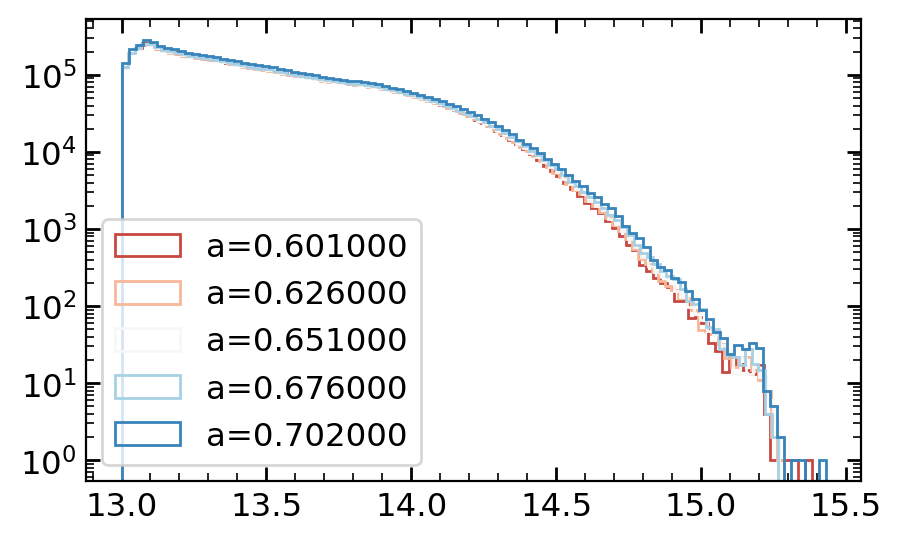

In [26]:
f, ax = plt.subplots(1, 1, figsize=(5,3))
ax.semilogy()

cmap = sns.color_palette('RdBu', n_colors=len(keys))
with h5py.File(join(sdir, 'halos.h5'), 'r') as f:
    keys = list(f.keys())
    for i, key in enumerate(keys):
        hmass = np.array(f[key]['mass'])
        print(hmass[0])
        ax.hist(hmass, bins=100, histtype='step', label=f'a={key}', color=cmap[i])
ax.legend();

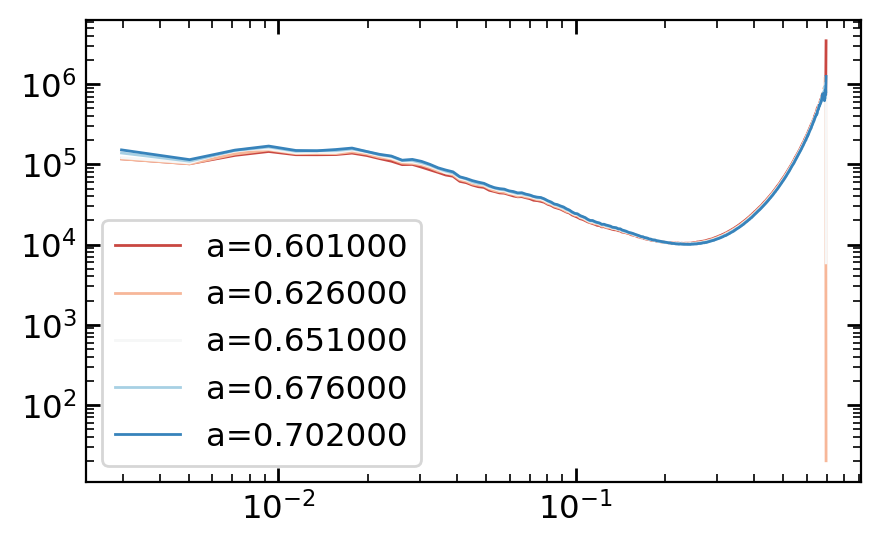

In [29]:
f, ax = plt.subplots(1, 1, figsize=(5,3))
ax.loglog()

cmap = sns.color_palette('RdBu', n_colors=len(keys))
with h5py.File(join(sdir, 'halos.h5'), 'r') as f:
    keys = list(f.keys())
    for i, key in enumerate(keys):
        hpos = np.array(f[key]['pos']).astype(np.float32)

        halo_field = np.zeros((384, 384, 384)).astype(np.float32)
        MASL.MA(hpos, halo_field, BoxSize=3000, MAS='NGP', verbose=False)

        halo_field /= np.mean(halo_field)
        halo_field -= 1

        Pk = PKL.Pk(halo_field, BoxSize=3000, axis=0, MAS='CIC', verbose=False)
        ax.plot(Pk.k3D, Pk.Pk[:,0], label=f'a={key}', color=cmap[i], lw=1)
ax.legend()

In [4]:
with h5py.File(join(sdir, 'obs', 'lightcone0.h5')) as f:
    ra = f['ra'][...]
    dec = f['dec'][...]
    z = f['z'][...]
    galsnap = f['galsnap'][...]
    galidx = f['galidx'][...]

zcount = np.genfromtxt('../cmass/lightcone/nz_DR12v5_CMASS_North_zmin0.4000_zmax0.7000.dat',
                       delimiter='\n')

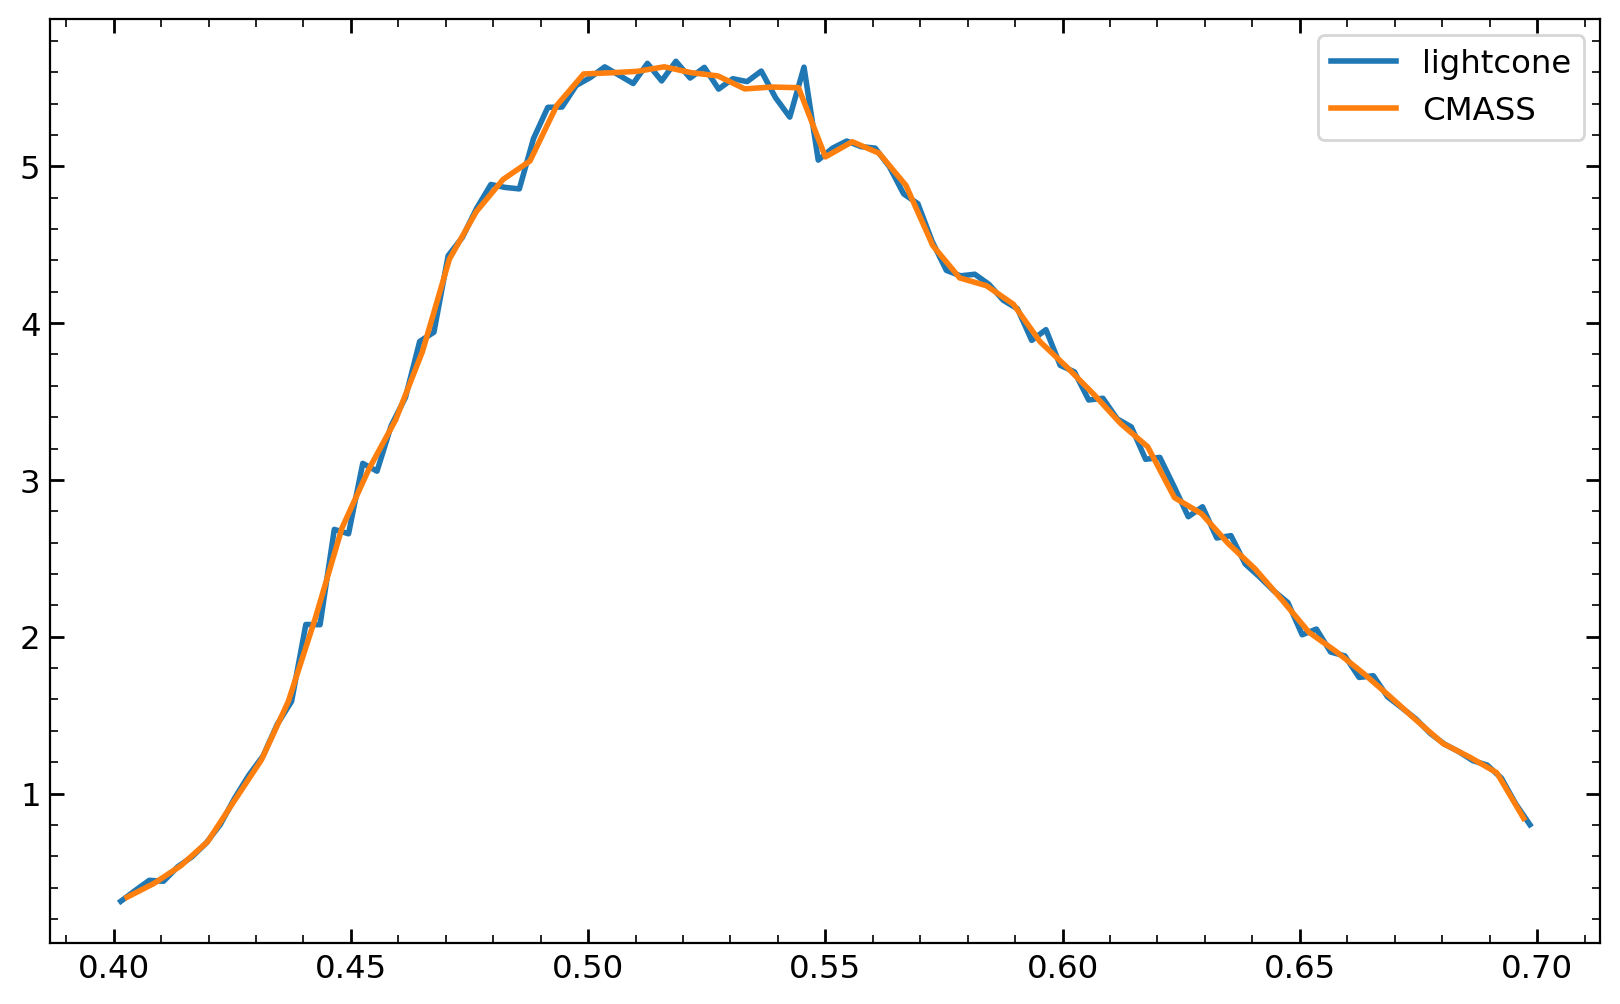

In [5]:
# plot the sim lightcone redshift distribution
h, be = np.histogram(z, bins=100, density=True)
bc = (be[1:] + be[:-1])/2
plt.plot(bc, h, label='lightcone')

# plot the CMASS redshift distribution
_x = np.linspace(0.4, 0.7, len(zcount)+1)
_x = (_x[1:] + _x[:-1])/2
plt.plot(_x, zcount/np.sum(zcount)/np.diff(_x[:2]), label='CMASS')

plt.legend()